In [1]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 38.9MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/daily-climate-time-series-data.zip', 'r')
zip_ref.extractall('/content/sets')
zip_ref.close()


In [8]:
import numpy as np # lib numpy
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [9]:
data_train = pd.read_csv('/content/sets/DailyDelhiClimateTrain.csv')
data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


dalam datasest ini terdapat colom berupa "waktu, temperatur rata-rata,kelembapan, kecepatan angin, tekanan rata-rata"

In [10]:
data_train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [11]:
data_train.isnull().sum()


date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

melihat apakah ada nilau value yang kosong

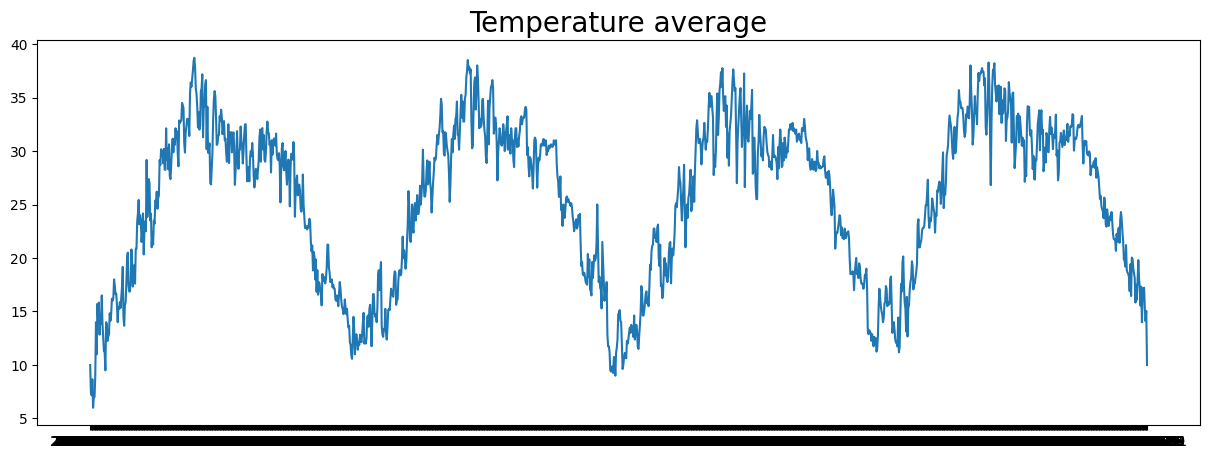

In [12]:
dates = data_train['date'].values
temp  = data_train['meantemp'].values


plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

menampilkan plot temperatur dari januari 2013 sampai januari 2017

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

code ini berfungsi untuk mengubah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

In [14]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

Membuat model dengan LSTM.  Ketika menggunakan 2 buah layer LSTM, perhatikan bahwa layer pertama harus memiliki parameter return_sequences yang bernilai True.

In [15]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
15/15 [==============================] - 6s 101ms/step - loss: 20.0095 - mae: 20.5077
Epoch 2/100
15/15 [==============================] - 2s 123ms/step - loss: 7.6409 - mae: 8.1292
Epoch 3/100
15/15 [==============================] - 3s 159ms/step - loss: 7.0580 - mae: 7.5447
Epoch 4/100
15/15 [==============================] - 2s 98ms/step - loss: 5.2064 - mae: 5.6903
Epoch 5/100
15/15 [==============================] - 2s 97ms/step - loss: 5.3281 - mae: 5.8068
Epoch 6/100
15/15 [==============================] - 2s 97ms/step - loss: 4.5583 - mae: 5.0398
Epoch 7/100
15/15 [==============================] - 2s 102ms/step - loss: 3.3951 - mae: 3.8662
Epoch 8/100
15/15 [==============================] - 3s 159ms/step - loss: 2.6159 - mae: 3.0789
Epoch 9/100
15/15 [==============================] - 2s 106ms/step - loss: 5.9952 - mae: 6.4778
Epoch 10/100
15/15 [==============================] - 2s 97ms/step - loss: 4.6323 - mae: 5.1120
Epoch 11/100
15/15 [=====================

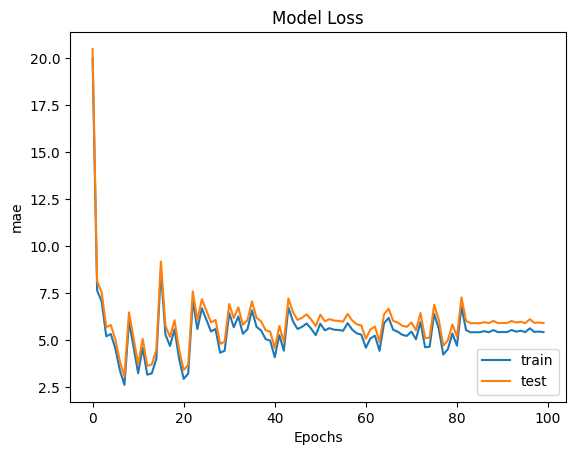

In [19]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')

plt.plot(history.history['mae'])
plt.title('Model Loss')
plt.ylabel('mae')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

plt.show()
